In [1]:
import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark import SparkConf

sc = SparkContext(master = 'local', appName = 'combined cycle power plant')

spark = SparkSession(sc)

In [2]:
import pandas as pd
df1 = pd.read_excel('CCPP/Folds5x2_pp.xlsx', sheet_name='Sheet1',inferSchema='')

In [3]:
data1 = spark.createDataFrame(df1)

In [4]:
df2 = pd.read_excel('CCPP/Folds5x2_pp.xlsx', sheet_name='Sheet2',inferSchema='')
df3 = pd.read_excel('CCPP/Folds5x2_pp.xlsx', sheet_name='Sheet3',inferSchema='')
df4 = pd.read_excel('CCPP/Folds5x2_pp.xlsx', sheet_name='Sheet4',inferSchema='')
df5 = pd.read_excel('CCPP/Folds5x2_pp.xlsx', sheet_name='Sheet5',inferSchema='')

In [5]:
data2 = spark.createDataFrame(df2)
data3 = spark.createDataFrame(df3)
data4 = spark.createDataFrame(df4)
data5 = spark.createDataFrame(df5)

In [6]:
data1.count()

9568

In [7]:
data5.count()

9568

# We use data1 first, then try with other datasets later

In [8]:
data1.count() - data1.distinct().count()

41

In [9]:
from pyspark.sql.functions import *
data1.select([count(when(isnan(col), col)).alias(col) for col in data1.columns]).show()

+---+---+---+---+---+
| AT|  V| AP| RH| PE|
+---+---+---+---+---+
|  0|  0|  0|  0|  0|
+---+---+---+---+---+



In [10]:
data1.select([count(when(isnull(col), col)).alias(col) for col in data1.columns]).show()

+---+---+---+---+---+
| AT|  V| AP| RH| PE|
+---+---+---+---+---+
|  0|  0|  0|  0|  0|
+---+---+---+---+---+



In [11]:
data1.printSchema()

root
 |-- AT: double (nullable = true)
 |-- V: double (nullable = true)
 |-- AP: double (nullable = true)
 |-- RH: double (nullable = true)
 |-- PE: double (nullable = true)



# Average of all columns

In [12]:
data1.select('PE').agg({'PE': 'avg'}).show()

+-----------------+
|          avg(PE)|
+-----------------+
|454.3650094063554|
+-----------------+



In [13]:
data1.select('AT').agg({'AT': 'avg'}).show()

+-----------------+
|          avg(AT)|
+-----------------+
|19.65123118729102|
+-----------------+



In [14]:
data1.select('V').agg({'V': 'avg'}).show()

+-----------------+
|           avg(V)|
+-----------------+
|54.30580372073601|
+-----------------+



In [15]:
data1.select('AP').agg({'AP': 'avg'}).show()

+------------------+
|           avg(AP)|
+------------------+
|1013.2590781772603|
+------------------+



In [16]:
data1.select('RH').agg({'RH': 'avg'}).show()

+-----------------+
|          avg(RH)|
+-----------------+
|73.30897784280926|
+-----------------+



In [17]:
data1 = data1.drop_duplicates()
data1.count() - data1.distinct().count()

0

# Correlation between these columns and visualization of all columns for finding insights

In [18]:
import matplotlib.pyplot as plt
import seaborn as sb

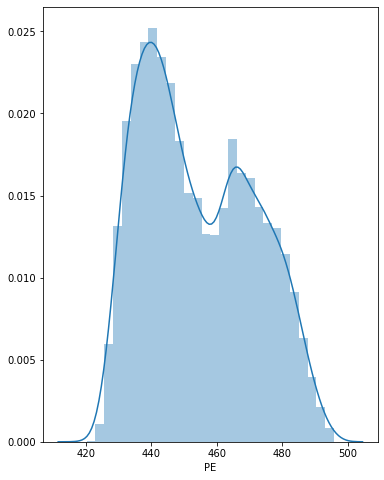

In [19]:
df1 = data1.toPandas()
plt.figure(figsize = (6, 8))
sb.distplot(df1['PE'])
plt.show()

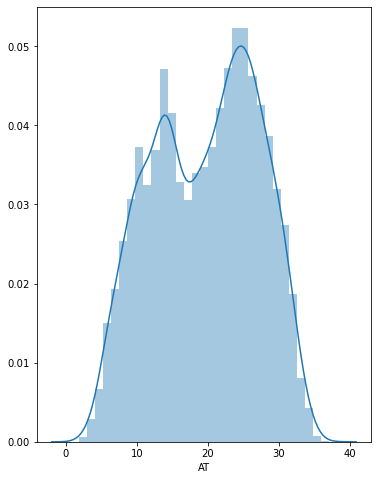

In [20]:
plt.figure(figsize = (6, 8))
sb.distplot(df1['AT'])
plt.show()

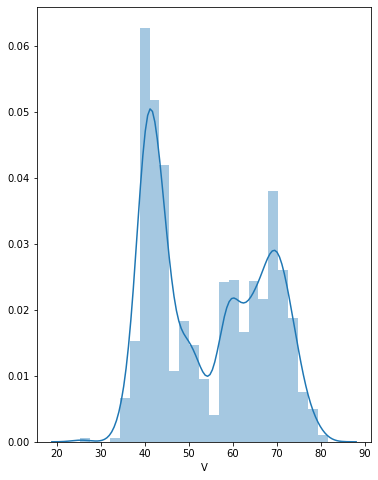

In [21]:
plt.figure(figsize = (6, 8))
sb.distplot(df1['V'])
plt.show()

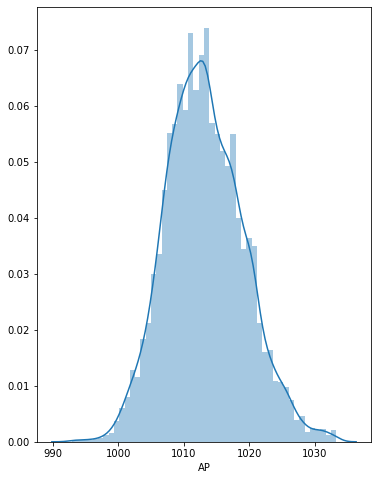

In [22]:
plt.figure(figsize = (6, 8))
sb.distplot(df1['AP'])
plt.show()

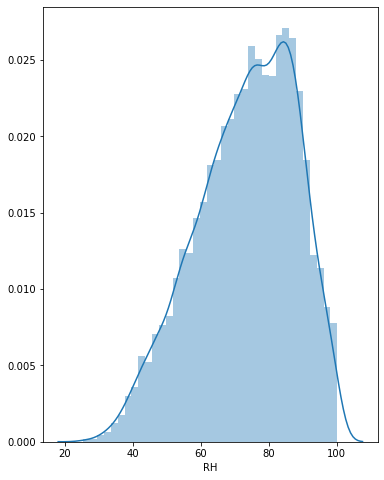

In [23]:
plt.figure(figsize = (6, 8))
sb.distplot(df1['RH'])
plt.show()

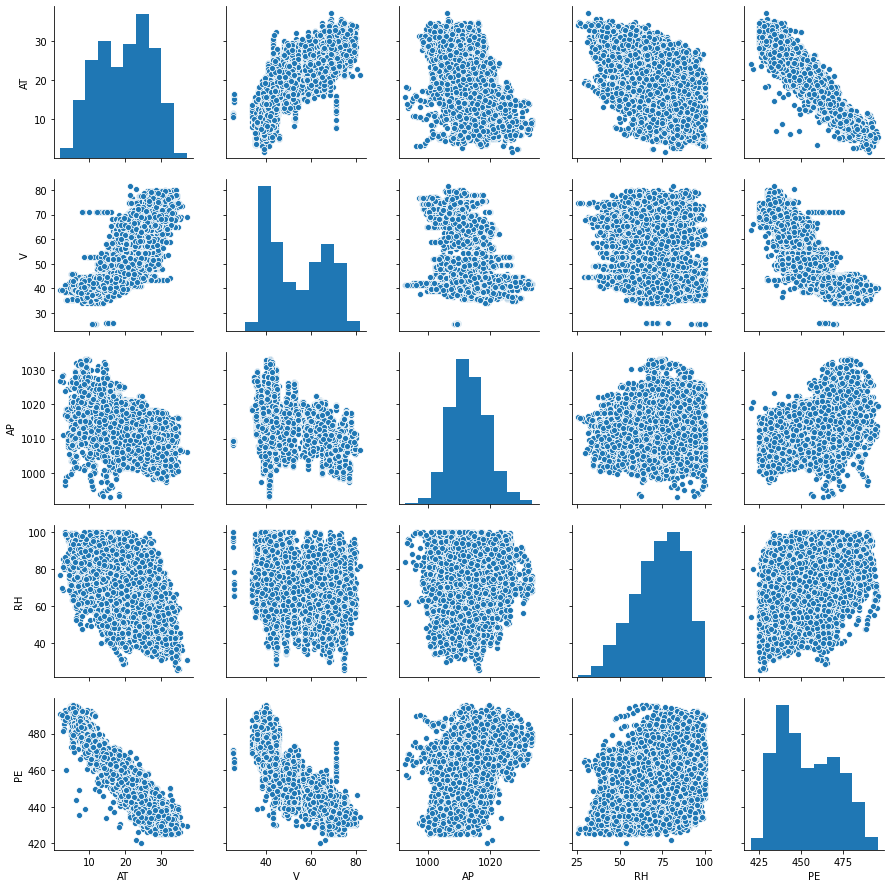

In [24]:
sb.pairplot(df1)

In [25]:
df1.corr()

,AT,V,AP,RH,PE
AT,1.000000,0.843689,-0.508222,-0.543947,-0.947908
V,0.843689,1.000000,-0.415718,-0.312214,-0.869900
AP,-0.508222,-0.415718,1.000000,0.101631,0.518687
RH,-0.543947,-0.312214,0.101631,1.000000,0.391175
PE,-0.947908,-0.869900,0.518687,0.391175,1.000000


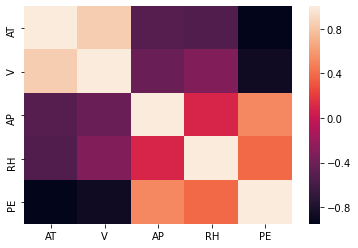

In [26]:
sb.heatmap(data = df1.corr())

# With these charts, I detect that: 

1. Almost of columns does not follow normal distribution 
2. We need to scale data 
3. V and AT have negative correlation with PE, but they are almost strong correlation with absolute values are greater than 0.5 
4. RH may be not good for predictio, so we can think of skipping it when we obtain a low score of accuracy
5. All datasets seems not have outliers that we can skip this step

# Scaling:
- The first dataset is Min Max Scaling because we would like to keep the shape of all data columns.
- The second dataset is Standard Scaling.

In [27]:
def min_max_scaler(df, cols_to_scale):
    for col in cols_to_scale:
        max_values = df.agg({col: 'max'}).collect()[0][0]
        min_values = df.agg({col: 'min'}).collect()[0][0]
        new_column_name = 'scaled_' + col
        
        df = df.withColumn(new_column_name, (df[col] - min_values)/(max_values - min_values))
    return df

In [28]:
cols_to_scale = data1.columns
data1_minmax = min_max_scaler(data1, cols_to_scale)

In [29]:
data1_minmax.show(5)

+-----+-----+-------+-----+------+-------------------+-------------------+-------------------+-------------------+-------------------+
|   AT|    V|     AP|   RH|    PE|          scaled_AT|           scaled_V|          scaled_AP|          scaled_RH|          scaled_PE|
+-----+-----+-------+-----+------+-------------------+-------------------+-------------------+-------------------+-------------------+
|24.54|60.29|1017.42|58.94|447.67| 0.6439093484419264| 0.6215302491103203| 0.6070279633754019|0.44745308310991955| 0.3630463576158944|
|10.59|42.49|1009.59|77.36|477.49|0.24872521246458923| 0.3048042704626335| 0.4132640435535773| 0.6943699731903485| 0.7580132450331128|
| 26.7|66.56|1005.31|71.97|430.21| 0.7050991501416431| 0.7330960854092526| 0.3073496659242754|  0.622117962466488|0.13178807947019852|
|21.24|41.67| 1012.6|49.27|459.81| 0.5504249291784703|0.29021352313167265| 0.4877505567928743|0.31782841823056307| 0.5238410596026492|
|27.74|74.78|1010.05|60.82|436.87| 0.7345609065155808| 

In [30]:
def standard_scaler(df, cols_to_scale):
    for col in cols_to_scale:
        mean_values = df.agg({col: 'mean'}).collect()[0][0]
        stddev_values = df.agg({col: 'stddev'}).collect()[0][0]
        new_column_name = 'scaled_' + col
        
        df = df.withColumn(new_column_name, (df[col] - mean_values)/stddev_values)
    return df

In [31]:
cols_to_scale = data1.columns
data1_std = standard_scaler(data1, cols_to_scale)

In [32]:
data1_std.show(5)

+-----+-----+-------+-----+------+-------------------+-------------------+--------------------+--------------------+-------------------+
|   AT|    V|     AP|   RH|    PE|          scaled_AT|           scaled_V|           scaled_AP|           scaled_RH|          scaled_PE|
+-----+-----+-------+-----+------+-------------------+-------------------+--------------------+--------------------+-------------------+
|24.54|60.29|1017.42|58.94|447.67| 0.6557649872985835| 0.4726811550576459|  0.7041322397322972| -0.9854484430114219|-0.3912129856069883|
|10.59|42.49|1009.59|77.36|477.49|-1.2181275326167487|-0.9304062194377138|  -0.613932846532052|  0.2755464765946167|  1.358881460657908|
| 26.7|66.56|1005.31|71.97|430.21| 0.9459160871564415| 0.9669147414669668| -1.3344077595858939|-0.09344172192202548| -1.415916172454244|
|21.24|41.67| 1012.6|49.27|459.81|0.21247858473796716|-0.9950428288245788|-0.10724371375354419| -1.6474365468436905|0.32126677890192595|
|27.74|74.78|1010.05|60.82|436.87|  1.085

# Processing data and training model

In [33]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [34]:
assembler = VectorAssembler(
    inputCols = ['scaled_AT', 'scaled_AP', 'scaled_V', 'scaled_RH'],
    outputCol='features')

In [35]:
data_pre = assembler.transform(data1_minmax)
data_pre.show(5)

+-----+-----+-------+-----+------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+
|   AT|    V|     AP|   RH|    PE|          scaled_AT|           scaled_V|          scaled_AP|          scaled_RH|          scaled_PE|            features|
+-----+-----+-------+-----+------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+
|24.54|60.29|1017.42|58.94|447.67| 0.6439093484419264| 0.6215302491103203| 0.6070279633754019|0.44745308310991955| 0.3630463576158944|[0.64390934844192...|
|10.59|42.49|1009.59|77.36|477.49|0.24872521246458923| 0.3048042704626335| 0.4132640435535773| 0.6943699731903485| 0.7580132450331128|[0.24872521246458...|
| 26.7|66.56|1005.31|71.97|430.21| 0.7050991501416431| 0.7330960854092526| 0.3073496659242754|  0.622117962466488|0.13178807947019852|[0.70509915014164...|
|21.24|41.67| 1012.6|49.27|459.81| 0.5504249291784703|0.29021352

In [36]:
final_data = data_pre.select('features', 'scaled_PE').withColumnRenamed('scaled_PE', 'output')

In [37]:
final_data.show(5)

+--------------------+-------------------+
|            features|             output|
+--------------------+-------------------+
|[0.64390934844192...| 0.3630463576158944|
|[0.24872521246458...| 0.7580132450331128|
|[0.70509915014164...|0.13178807947019852|
|[0.55042492917847...| 0.5238410596026492|
|[0.73456090651558...|0.22000000000000017|
+--------------------+-------------------+
only showing top 5 rows



In [38]:
train_data, test_data = final_data.randomSplit([0.8,0.2])

# Linear Regression

In [39]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol = "features", 
                      labelCol = 'output')

In [40]:
lrModel = lr.fit(train_data)

In [41]:
print('Coefficients:', lrModel.coefficients)

Coefficients: [-0.9145151631500475,0.0323625302674822,-0.18176931800512555,-0.15210093024916782]


In [42]:
print('Slope:', lrModel.intercept)

Slope: 1.0880757358759088


In [43]:
test_results = lrModel.evaluate(test_data)

print('RMSE:', test_results.rootMeanSquaredError)
print('MSE:', test_results.meanSquaredError)
print('R2:', test_results.r2)

RMSE: 0.059035396262582585
MSE: 0.00348517801188015
R2: 0.9314857288508294


The result is good with R2 score being approximately 0.93

# We try with Decision Tree Regressor and GBT

In [46]:
from pyspark.ml.regression import DecisionTreeRegressor

model = DecisionTreeRegressor(featuresCol ='features', labelCol = 'output')

In [47]:
dtModel = model.fit(train_data)

In [53]:
from pyspark.ml.evaluation import RegressionEvaluator
dt_evaluator = RegressionEvaluator(labelCol="output", predictionCol="prediction", metricName="r2")

In [55]:
predictions = dtModel.transform(test_data)
test_results = dt_evaluator.evaluate(predictions)

print('r2 score:', test_results)

r2 score: 0.9337737245520037


In [56]:
from pyspark.ml.regression import GBTRegressor
gbt = GBTRegressor(featuresCol = 'features', labelCol = 'output', maxIter=20)
gbt_model = gbt.fit(train_data)
gbt_predictions = gbt_model.transform(test_data)
gbt_predictions.select('prediction', 'output', 'features').show(5)

+-------------------+-------------------+--------------------+
|         prediction|             output|            features|
+-------------------+-------------------+--------------------+
| 0.7989193263753449| 0.8376158940397352|[0.18895184135977...|
| 0.6005052114620298| 0.5266225165562912|[0.38413597733711...|
| 0.3176066122584235|0.25920529801324493|[0.62237960339943...|
|0.30972374992946733|0.26238410596026496|[0.69093484419263...|
| 0.1501355693508868| 0.1524503311258277|[0.82549575070821...|
+-------------------+-------------------+--------------------+
only showing top 5 rows



In [57]:
gbt_evaluator = RegressionEvaluator(
    labelCol="output", predictionCol="prediction", metricName="r2")
r2 = gbt_evaluator.evaluate(gbt_predictions)
print("R2 score = %g" % r2)

R2 score = 0.948813


# Conclusion: 
The most effective model is GRADIENT BOOSTED TREE with r2 score is up to 94.9%, We can use another regression model apart from 3 above. After that, we can save model for purpose of prediction in the future